### Import libraries and set parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests, time, re
import datetime as dt

from psaw import PushshiftAPI
from textblob import TextBlob

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from ipywidgets import widgets, interact, interact_manual, fixed
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 5000

### Define functions to be used in this notebook

#### Function: Get reddit (subreddit) posts through PushshiftAPI via the psaw wrapper

In [2]:
# Function: Get reddit (subreddit) posts through PushshiftAPI via the psaw wrapper.
#  subreddit: The subreddit that you want to collect data from.
#  start_date: start date.
#  end_date: end date.
#  submissions: Default=True. If True, collect submissions.
#  comments: Default=False. If True, collect comments.
#  Documentation: 
#   psaw: https://github.com/dmarx/psaw
#   PushshiftAPI: https://github.com/pushshift/api
def reddit_collect(subreddit, start_date, end_date, submissions=True, comments=False):
    
    # Instantiate PushshiftAPI
    api = PushshiftAPI()
    
    # Set start and end dates to epoch format
    sy = int(start_date.split('-')[0])
    sm = int(start_date.split('-')[1])
    sd = int(start_date.split('-')[2])
    ey = int(end_date.split('-')[0])
    em = int(end_date.split('-')[1])
    ed = int(end_date.split('-')[2])
    start_epoch = int(dt.datetime(sy, sm, sd).timestamp())
    end_epoch = int(dt.datetime(ey, em, ed).timestamp())
    
    if submissions:
        # Collect submissions
        post_type = 's'
        print("For subreddit '{0}' collecting submissions from {1} till {2}".format(subreddit, start_date, end_date))
        submissions = list(api.search_submissions(after=start_epoch,
                                    before=end_epoch, 
                                    #limit=10,
                                    subreddit=subreddit,
                                    filter=['id','author', 'title', 'subreddit']))
        print(" Number of submissions: {}".format(len(submissions))) 
        submissions = pd.DataFrame(submissions).drop('d_', axis=1)
        submissions['type'] = 'submission'
        submissions = submissions.rename(index=str, columns={"title": "body"})
        df = submissions
        
    if comments:
        # Collect comments
        post_type = 'sc'
        print("For subreddit '{0}' collecting comments from {1} till {2}".format(subreddit, start_date, end_date))
        comments = list(api.search_comments(after=start_epoch,
                                    before=end_epoch, 
                                    #limit=10,
                                    subreddit=subreddit,
                                    filter=['id','author', 'body', 'subreddit']))
        print(" Number of comments: {}".format(len(comments)))
        comments = pd.DataFrame(comments).drop('d_', axis=1)
        comments['type'] = 'comment'
        df = pd.concat([submissions, comments], ignore_index=True)
        
    # Write to file
    filename = subreddit + "_" + post_type + "_" + str(sy) + str(sm) + str(sd) + "_" + str(ey) + str(em) + str(ed)
    df.to_csv('../data/' + filename + '_reddit.csv')
    
    return df

#### Function: Transform text input to cleaned, corrected, and vectorized feature set as a dataframe

In [3]:
# Function: Transform text input to cleaned, corrected, and vectorized feature set as a dataframe.
#  X: pd.Series of text to prepare into feature set.
#  lowercase: Default=True. If True, convert to lowercase text.
#  max_features: Default=5000. Limit maximum feature set.
#  spellcheck: Default-False, If True, attempt to correct spellings (computing intensive operation).
def reddit_prepare_features(X, lowercase=True, max_features=5000, spellcheck=False):
    
    # Fix spellings (computing heavy operation)
    if spellcheck:
        X = X.map(lambda x: str(TextBlob(x).correct()))
    
    # Convert text to lowercase
    X = X.str.lower()
    
    # Remove un-needed regex patterns
    X = X.str.replace('r[\b[^\d\W]+\b]', '')    
    
    
    #Transform text to counts of words using CountVectorizer
    vectorizer = CountVectorizer(analyzer='word', 
                                 ngram_range=(1, 2), 
                                 stop_words='english',
                                 max_features=max_features)
    
    X = vectorizer.fit_transform(X)  
    X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    return X

#### Function: Create wordcloud from a text series

In [4]:
# Function: Create wordcloud from a text series.
#  text_series: a text series (column from a dataframe) from which the wordcloud will be generated.
#  name: Default=None. The name of the subreddit.
def reddit_create_wordcloud(text_series, name=None):

    # Combine body into one corpus string
    corpus = " ".join(body for body in text_series)
    #print ("There are {0:,} words in the '{1}' subreddit.".format(len(corpus), name))

    # Create stopword list
    stopwords = set(STOPWORDS)
    stopwords.update([]) # Include any additional stopwords specific to this corpus.

    print ("Subreddit '{0}':".format(name))
    wordcloud = WordCloud(stopwords=stopwords, max_words=200, background_color="white")
    wordcloud.generate(corpus)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Function: Build, fit, and evaluate model

In [5]:
# Function: Build, fit, and evaluate model.
#  model: Specify model type to use.
#          'lr': LogisticRegression.
#          'rf': RandomForestClassifier.
#  X: Feature variables.
#  y: Target variable.
def reddit_model_fit_score(model, X, y):
    
    # Split dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    
    # Use model 'lr': LogisticRegression
    if model == 'lr':
        model_type = 'LogisticRegression'
        # Instantiate, fit, and predict
        lr = LogisticRegression()
        model = lr.fit(X_train, y_train)
        predictions = lr.predict(X_train)
        # Evaluate model
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        score_cv_train = cross_val_score(lr, X_train, y_train, cv=kf).mean()
        score_train = lr.score(X_train, y_train)
        score_test = lr.score(X_test, y_test)
        print("Using a {0} model we get the following scores:".format(model_type))
        print(" Accuracy (cross_validated) on training data: {0:.2f}".format(score_cv_train))
        print(" Accuracy on training data: {0:.2f}".format(score_train))
        print(" Accuracy on testing data: {0:.2f}".format(score_test))
        print("")
        
        
    # Use model 'rf': RandomForestClassifier
    if model == 'rf':
        model_type = 'RandomForestClassifier'
        # Instantiate, fit, and predict
        rf = RandomForestClassifier()
        model = rf.fit(X_train, y_train)
        predictions = rf.predict(X_train)
        # Evaluate model
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        score_cv_train = cross_val_score(rf, X_train, y_train, cv=kf).mean()
        score_train = rf.score(X_train, y_train)
        score_test = rf.score(X_test, y_test)
        print("Using a {0} model we get the following scores:".format(model_type))
        print(" Accuracy (cross_validated) on training data: {0:.2f}".format(score_cv_train))
        print(" Accuracy on training data: {0:.2f}".format(score_train))
        print(" Accuracy on testing data: {0:.2f}".format(score_test))

    
    # Return model used
    return model

#### Function: Equalize testing data columns by imputing missing features with null values. In addition, remove features not in model

In [6]:
# Function: Equalize testing data columns by imputing missing features with null values. In addition, remove features not in model.
#  model_features: list of features in model.
#  new_df: new dataframe.
def reddit_equalize_features(model_features, new_df):
    new_features = new_df.columns.tolist()
    if set(model_features) != set(new_features):
        missing_cols = set(model_features) - set(new_features)
        for col in missing_cols:
            new_df[col] = 0
    
    if set(new_features) != set(model_features):
        missing_cols = set(new_features) - set(model_features)
        new_df = new_df.drop(missing_cols, axis=1)
    
    new_df = new_df[model_features]
    return new_df

#### Function: Apply model to sample dataset and generate predictions

In [7]:
# Function: Apply model to sample dataset and generate predictions.
#  model: model object to use (generated from training dataset).
#  X: dataframe of sample features.
#  showcase: Default=False. If showcase=True, then do not print output .
def reddit_sample_predictions(model, X, showcase=False):
    predictions = model.predict(X)
    if not showcase:
        print(model)
        print("")
        
    return predictions

#### Function: Process input from widget textbox and display predictions

In [8]:
# Function: Process input from widget textbox and display predictions.
#  incoming: input text from textbox.
def on_text_submit(incoming):
    line_divider = widgets.Output(layout={'border': '1px solid black'}) 
    display(line_divider)
    print("Message:")
    print(incoming.value)
    new_posts = incoming.value
    # Process new post to ascertain classification
    new_posts_featurized = reddit_prepare_features(pd.Series(new_posts)) # Featurize new post
    new_posts_featurized = reddit_equalize_features(X_features, new_posts_featurized) # Only utilize features actually modeled
    predictions = reddit_sample_predictions(model, new_posts_featurized, showcase=True) # Generate predictions 
    # Convert predictions to dataframe
    df_predictions = pd.DataFrame(columns=['classification', 'post'])
    df_predictions['classification'] = predictions
    df_predictions['post'] = new_posts
    print("Result:")
    for e in df_predictions['classification']:
        if e == 0: print("That is a sad message.\nConsider watching some furry animal videos while listening to 'Somewhere Over the Rainbow.'")
        else: print("That is a happy message.\nThat makes me happy as well :-)")

# 1. Define problem

In [9]:
# Which subreddit does a post belong to?
#  Gather data from reddit and using NLP on the title/text classify post as either 1 or 0
#  In this case, 1 = happy (from a subreddit called happy), and 0 = sad (from a subreddit called sad)

# 2. Gather data

In [10]:
# Collect data from happy subreddit.
#happy = reddit_collect("happy", "2016-1-1", "2018-12-19", submissions=True, comments=True)

In [11]:
# Collect data from sad subreddit.
#sad = reddit_collect("sad", "2010-1-1", "2018-12-19", submissions=True, comments=True)

In [12]:
# Read csv files containing 'happy' and 'sad' dataset from reddit.
df_happy = pd.read_csv('../data/happy_sc_201611_20181219_reddit.csv')
df_sad = pd.read_csv('../data/sad_sc_201011_20181219_reddit.csv')

In [13]:
# Concatenate datasets.
df = pd.concat([df_happy, df_sad], ignore_index=True)

# 3. Explore and transform data

In [14]:
# Basic dimensions, columns, and datatypes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366336 entries, 0 to 366335
Data columns (total 8 columns):
Unnamed: 0     366334 non-null object
author         366332 non-null object
body           366331 non-null object
created        366327 non-null object
created_utc    366327 non-null object
id             366327 non-null object
subreddit      366322 non-null object
type           366322 non-null object
dtypes: object(8)
memory usage: 22.4+ MB


In [15]:
# Header of dataset.
df.head()

,Unnamed: 0,author,body,created,created_utc,id,subreddit,type
0,0,pleasebringicedcoffe,My girlfriend and I just moved last week. We c...,1545209908,1545191908,a7itqz,happy,submission
1,1,OhMyItsButterflies,How do you find happiness? What did everyone h...,1545209618,1545191618,a7isfc,happy,submission
2,2,Sinfully_Delicious,After a really stressful end of quarter at uni...,1545209159,1545191159,a7iqdr,happy,submission
3,3,cant_decide_on_name_,Looking back on 2018,1545208569,1545190569,a7inou,happy,submission
4,4,Ruperts500,Some Happy Polls that you would love to answer.,1545205240,1545187240,a7i7l4,happy,submission


In [16]:
# Remove unneeded columns, rows with nulls, and any duplicate posts if present.
df = df.drop(['Unnamed: 0', 'created', 'created_utc'], axis=1)
df = df.drop_duplicates('id')
df = df.dropna()

In [17]:
# Only include submissions.
mask = (df['type'] == 'submission')
df = df.loc[mask, :]

In [18]:
# Insure relative balance of classes.
df['subreddit'].value_counts()

happy    25795
sad      19567
Name: subreddit, dtype: int64

In [19]:
# Convert target variable 'subreddit' to 1 = happy and 0 = sad.
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'happy' else 0)

Subreddit 'happy':


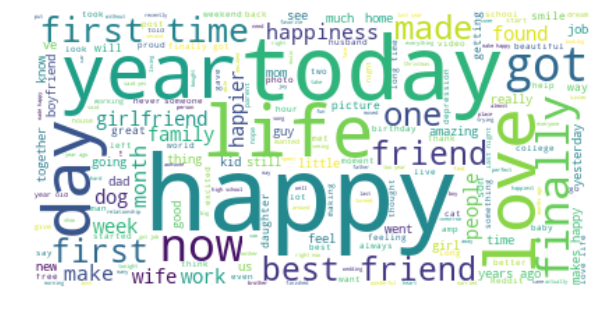

Subreddit 'sad':


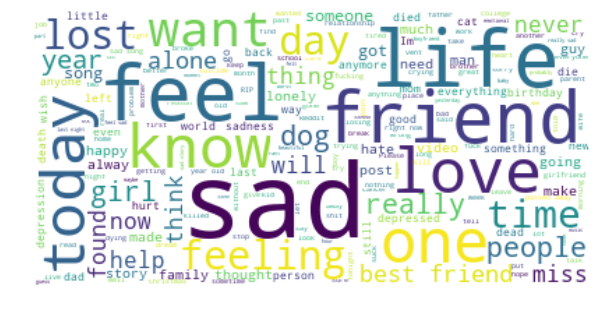

In [20]:
# Create wordcloud from happy subreddit.
reddit_create_wordcloud(df.loc[df['subreddit'] == 1, 'body'], name='happy')

# Create wordcloud from sad subreddit.
reddit_create_wordcloud(df.loc[df['subreddit'] == 0, 'body'], name='sad')

In [21]:
# Prepare feature set for model using text vectorization among other type sof pre-processing (see function for details).
X = reddit_prepare_features(df['body'], lowercase=True, max_features=10000)
X_features = X.columns.tolist()
print("Number of features in model: {0:,}".format(len(X_features)))

Number of features in model: 10,000


# 4. Build, fit, and evaluate model

In [22]:
# Set target variable and features.
y = df['subreddit']
X = X

In [23]:
# Fit and score model 'lr': LogisticRegression.
model_lr = reddit_model_fit_score('lr', X, y)

Using a LogisticRegression model we get the following scores:
 Accuracy (cross_validated) on training data: 0.85
 Accuracy on training data: 0.91
 Accuracy on testing data: 0.86



In [24]:
# Fit and score model 'rf': RandomForestClassifier.
model_rf = reddit_model_fit_score('rf', X, y)

Using a RandomForestClassifier model we get the following scores:
 Accuracy (cross_validated) on training data: 0.81
 Accuracy on training data: 0.97
 Accuracy on testing data: 0.82


In [25]:
# Set model to LogisticRegression since more generalized model and with higher accuracy than with a RandomForestClassifier.
model = model_lr

# 5. Answer problem

In [26]:
# Input new post and let model ascertain classification.
new_posts = ["I am so sad about how things are coming along",
           "I am so happy about how things are in my life",
            "I am so lonesome I could cry",
            "Mama says that, happiness is from magic rays of sunshine that come down when you're feeling blue...",
            "My mom always said life was like a box of chocolates. You never know what you're gonna get."]

In [27]:
# Process new post to ascertain classification.
new_posts_featurized = reddit_prepare_features(pd.Series(new_posts)) # Featurize new post
new_posts_featurized = reddit_equalize_features(X_features, new_posts_featurized) # Only utilize features actually modeled
predictions = reddit_sample_predictions(model, new_posts_featurized) # Generate predictions

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)



In [28]:
# Convert predictions to dataframe.
df_predictions = pd.DataFrame(columns=['classification', 'post'])
df_predictions['classification'] = predictions # 1='happy', 0='sad'
df_predictions['post'] = new_posts
df_predictions

,classification,post
0,0,I am so sad about how things are coming along
1,1,I am so happy about how things are in my life
2,0,I am so lonesome I could cry
3,1,"Mama says that, happiness is from magic rays o..."
4,1,My mom always said life was like a box of choc...


#### Interactive dashboard using ipywidgets

In [29]:
# Display input text box and handle on_submit.
#  To use simply input (or paste) text into the textbox below and hit Enter.
#  Note: To display the widget you have to 'restart and run all' the kernel again.
input_text = widgets.Text()
display(input_text)
input_text.on_submit(on_text_submit)

Text(value='')